# Cutoff exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.optimize import curve_fit
import os

In [4]:
CLEAN_DATA_PATH = '../../all_data_run_2511/data/cleaned_movie_data.csv'
# data cleaned without the cutoff part

df = pd.read_csv(CLEAN_DATA_PATH)

/tmp/ipykernel_134750/1016461305.py:4: DtypeWarning: Columns (4,16,17,18,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CLEAN_DATA_PATH)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98494 entries, 0 to 98493
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       98494 non-null  object 
 1   country                        97573 non-null  object 
 2   imdb_id                        97030 non-null  object 
 3   duration                       60861 non-null  float64
 4   duration_all                   60861 non-null  object 
 5   actors_id                      80068 non-null  object 
 6   actors                         80068 non-null  object 
 7   directors_id                   92282 non-null  object 
 8   directors                      92282 non-null  object 
 9   genre_id                       86172 non-null  object 
 10  genre                          86172 non-null  object 
 11  release_date                   98494 non-null  object 
 12  wikidata_class                 98494 non-null 

In [6]:
def log_func(x, a, b):
    return a * np.log(x) + b

fitted_params, _  = curve_fit(log_func, df['plot_length_tokens'], df['token_shannon_entropy'])

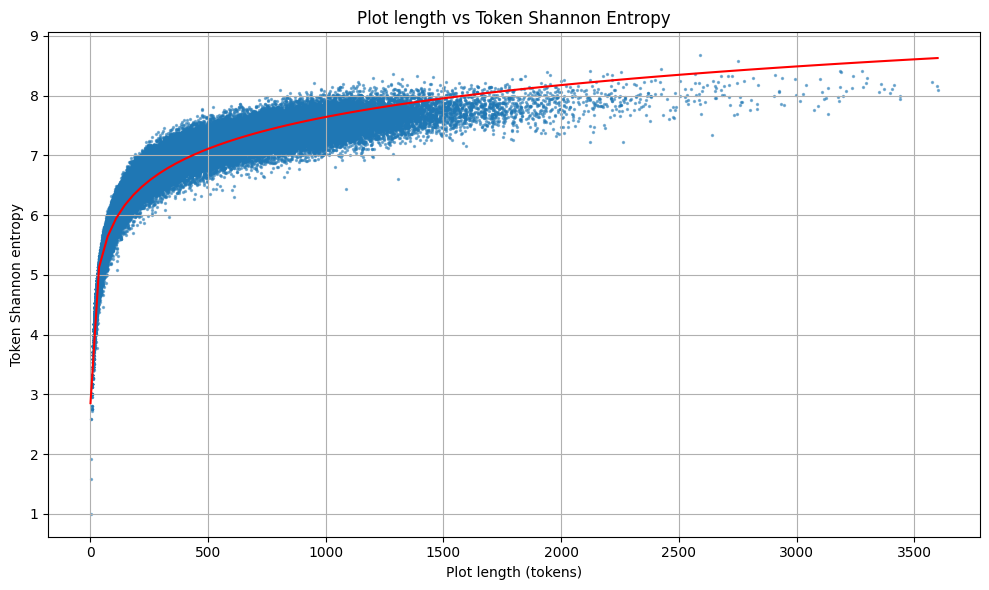

In [7]:
def plot_token_length_vs_entropy(data, fitted_params=fitted_params):
    plt.figure(figsize=(10, 6))
    plt.scatter(data['plot_length_tokens'], data['token_shannon_entropy'], s=2, alpha=0.5)
    x_vals = np.linspace(data['plot_length_tokens'].min(), data['plot_length_tokens'].max(), 100)
    if fitted_params is not None:
        y_vals = log_func(x_vals, *fitted_params)
        plt.plot(x_vals, y_vals, color='red', label='Fitted log function')
    plt.xlabel('Plot length (tokens)')
    plt.ylabel('Token Shannon entropy')
    plt.title('Plot length vs Token Shannon Entropy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_token_length_vs_entropy(df)

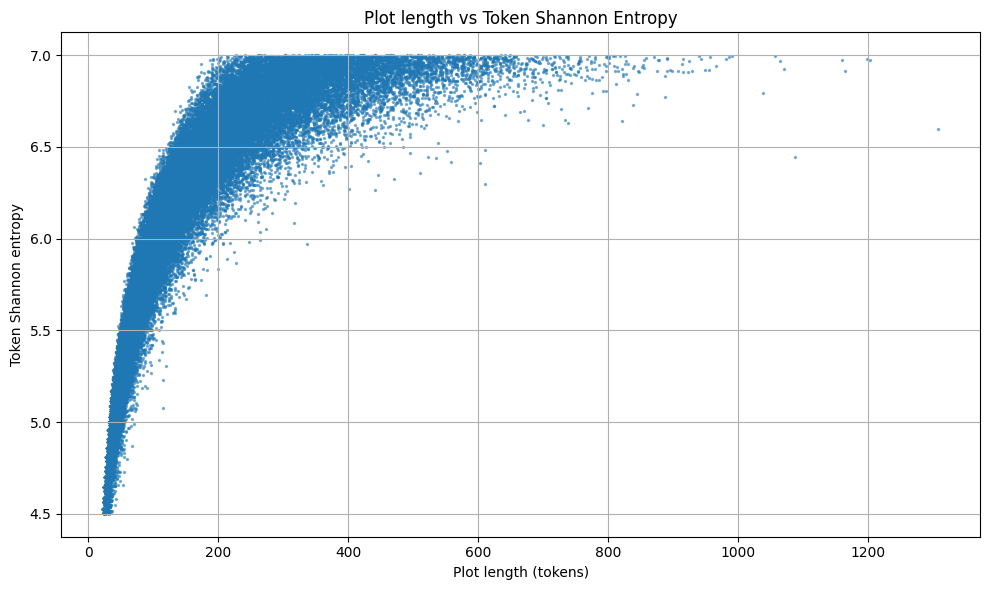

In [8]:
plot_token_length_vs_entropy(df[(df["token_shannon_entropy"] >= 4.5) & (df["token_shannon_entropy"] < 7)], None)

In [9]:
shannon_val_ranges = np.arange(4.5, 7.5, 0.5)
for i in range(len(shannon_val_ranges) - 1):
    lower_bound = shannon_val_ranges[i]
    upper_bound = shannon_val_ranges[i + 1]
    subset = df[(df["token_shannon_entropy"] >= lower_bound) & (df["token_shannon_entropy"] < upper_bound)]
    print(f"Shortest plot length for entropy range [{lower_bound}, {upper_bound}):\n", subset.iloc[subset['plot_length_tokens'].argmin()][["movie_id", "plot"]])
    print(f"Longest plot length for entropy range [{lower_bound}, {upper_bound}):\n", subset.iloc[subset['plot_length_tokens'].argmax()][["movie_id", "plot"]])

Shortest plot length for entropy range [4.5, 5.0):
 movie_id                                            Q18209203
plot        A series of violent murders are carried out by...
Name: 887, dtype: object
Longest plot length for entropy range [4.5, 5.0):
 movie_id                                             Q2354637
plot        The documentary is structured in segments: Par...
Name: 46866, dtype: object
Shortest plot length for entropy range [5.0, 5.5):
 movie_id                                             Q4973319
plot        A Chinese Buddhist missionary comes to London ...
Name: 3577, dtype: object
Longest plot length for entropy range [5.0, 5.5):
 movie_id                                             Q3051354
plot        Germaine, a housekeeper, has three customers: ...
Name: 25164, dtype: object
Shortest plot length for entropy range [5.5, 6.0):
 movie_id                                             Q3627697
plot        A retired radio disc jockey/actor (Ernest Borg...
Name: 74609, dtyp

## Sample from the approximate cut-off area 

In [18]:
interval_size = 0.1
intervals_start = 4.0
intervals_end = 5.0
num_per_interval = 10

sampled_data = pd.DataFrame()
for lower_bound in np.arange(intervals_start, intervals_end, interval_size):
    upper_bound = lower_bound + interval_size
    subset = df[(df["token_shannon_entropy"] >= lower_bound) & (df["token_shannon_entropy"] < upper_bound)]
    sampled_subset = subset.sample(n=min(num_per_interval, len(subset)), random_state=42)
    sampled_data = pd.concat([sampled_data, sampled_subset])

sampled_data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)
sampled_data[["movie_id", "plot"]].to_csv("cutoff_sampled_plots.csv", index=False)

In [10]:
annotated_data = pd.read_csv("cutoff_sampled_plots_annotated.csv")
annotated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  150 non-null    object
 1   plot      150 non-null    object
 2   good      150 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


In [11]:
annotated_data_full = annotated_data.merge(df, on="movie_id", how="left")
annotated_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       150 non-null    object 
 1   plot_x                         150 non-null    object 
 2   good                           150 non-null    int64  
 3   country                        149 non-null    object 
 4   imdb_id                        148 non-null    object 
 5   duration                       74 non-null     float64
 6   duration_all                   74 non-null     object 
 7   actors_id                      121 non-null    object 
 8   actors                         121 non-null    object 
 9   directors_id                   142 non-null    object 
 10  directors                      142 non-null    object 
 11  genre_id                       126 non-null    object 
 12  genre                          126 non-null    obj

In [12]:
from sklearn.metrics import fbeta_score

granularity = 0.0001
beta = 0.5

entropy = annotated_data_full['token_shannon_entropy'].values
y_true = annotated_data_full['good'].astype(int).values
    
thresholds = np.arange(entropy.min(), entropy.max(), granularity)
best_thresh = None
best_f_score = -1.0

for t in thresholds:
    y_pred = (entropy >= t).astype(int)
    f_score = fbeta_score(y_true, y_pred, beta=beta)
    if f_score > best_f_score:
        best_f_score = f_score
        best_thresh = t

print(f"Best cutoff: token_shannon_entropy {best_thresh:.4f}  -> F_beta = {best_f_score:.4f}")

Best cutoff: token_shannon_entropy 4.8398  -> F_beta = 0.8726


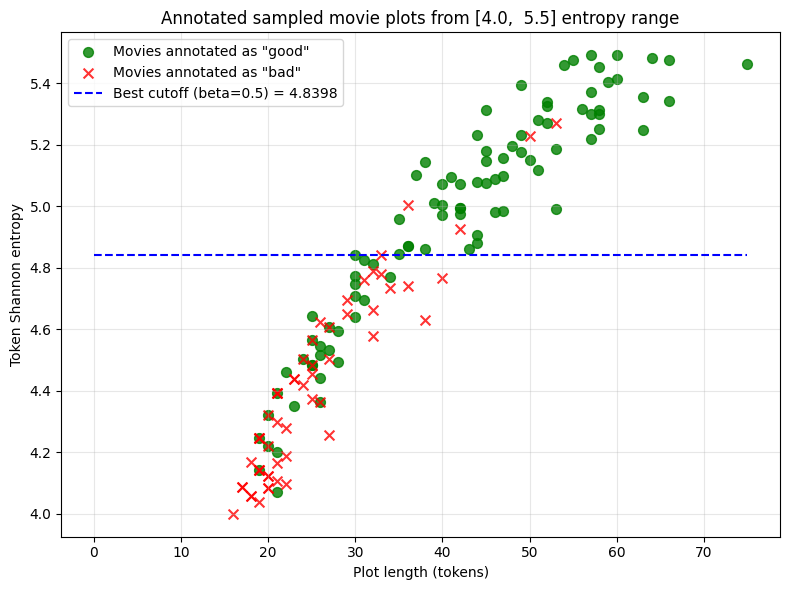

In [13]:
# scatter plot of annotated samples: length (tokens) vs token_shannon_entropy
fig, ax = plt.subplots(figsize=(8, 6))

good = annotated_data_full[annotated_data_full["good"] == 1]
bad  = annotated_data_full[annotated_data_full["good"] == 0]

ax.scatter(good["plot_length_tokens"], good["token_shannon_entropy"],
           c="green", marker="o", s=50, alpha=0.8, label='Movies annotated as "good"')
ax.scatter(bad["plot_length_tokens"], bad["token_shannon_entropy"],
           c="red", marker="x", s=50, alpha=0.8, label='Movies annotated as "bad"')
ax.plot([0, annotated_data_full["plot_length_tokens"].max()], [best_thresh, best_thresh], color='blue', linestyle='--', label=f'Best cutoff (beta={beta}) = {best_thresh:.4f}')

ax.set_xlabel("Plot length (tokens)")
ax.set_ylabel("Token Shannon entropy")
ax.set_title("Annotated sampled movie plots from [4.0,  5.5] entropy range")
ax.legend(frameon=True)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Post cut off analysis

In [14]:
filtered_df = df[df["token_shannon_entropy"] >= best_thresh]
len(filtered_df)

93696

In [15]:
print(f"Removed {len(df) - len(filtered_df)} movies below the cutoff from the dataset.")

Removed 4798 movies below the cutoff from the dataset.


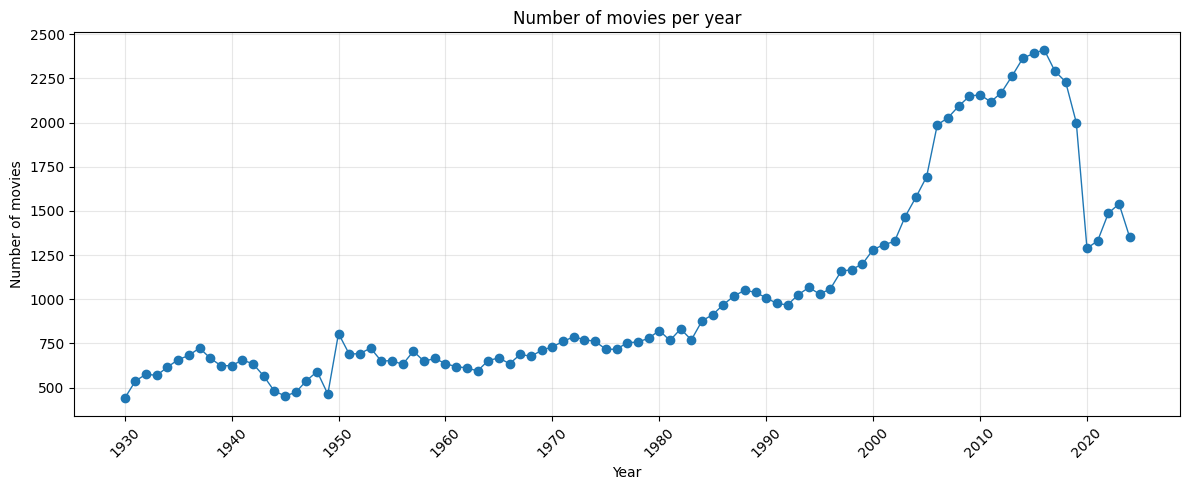

In [54]:
counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(counts.index, counts.values, marker='o', lw=1)
xticks = np.arange(counts.index.min(), counts.index.max() + 1, 10)
plt.xticks(xticks, rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies per year')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
filtered_df.iloc[filtered_df["token_shannon_entropy"].argmin()][["movie_id", "token_shannon_entropy"]]

movie_id                 Q1787422
token_shannon_entropy    4.840224
Name: 1022, dtype: object

In [38]:
filtered_df.iloc[filtered_df["plot_length_tokens"].argmin()][["movie_id", "token_shannon_entropy", "plot_length_tokens"]]

movie_id                 Q17028463
token_shannon_entropy     4.857981
plot_length_tokens              29
Name: 3174, dtype: object

In [16]:
df.iloc[df["token_shannon_entropy"].argmax()]

movie_id                                                                  Q2530135
country                                             Federal Republic of Yugoslavia
imdb_id                                                                  tt0116860
duration                                                                     115.0
duration_all                                                                   115
actors_id                        Q273474,Q299988,Q948201,Q1260865,Q1266719,Q128...
actors                           Branka Katić, Petar Božović, Velimir Bata Živo...
directors_id                                                               Q385312
directors                                                         Srđan Dragojević
genre_id                                                  Q130232,Q369747,Q7210294
genre                                        drama film, war film, political drama
release_date                                                  1996-05-09T00:00:00Z
wiki

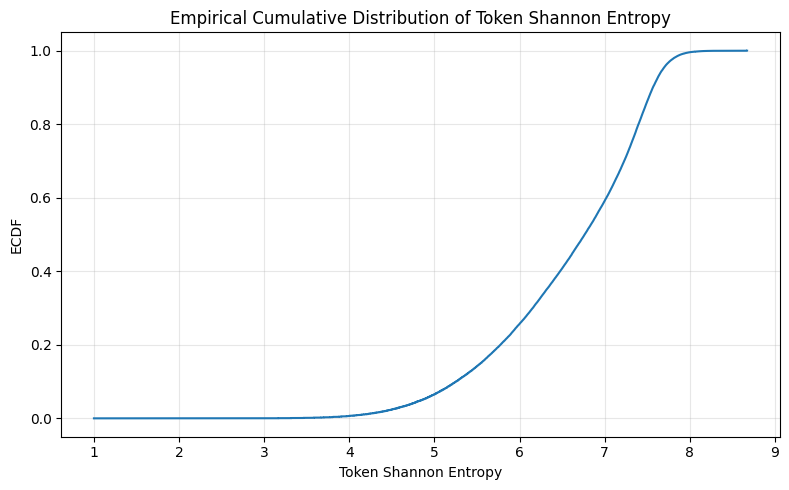

In [39]:
# Empirical Cumulative Distribution Function (ECDF) for token_shannon_entropy
entropy = df['token_shannon_entropy'].dropna().values
x = np.sort(entropy)
y = np.arange(1, len(x) + 1) / len(x)

plt.figure(figsize=(8, 5))
plt.step(x, y, where='post', lw=1.5)
plt.xlabel('Token Shannon Entropy')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution of Token Shannon Entropy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
df[(df["token_shannon_entropy"] >= 6.0) & (df["token_shannon_entropy"] <= 6.1)]["movie_id"]

103        Q2389826
190       Q18150785
203        Q2336856
212        Q3521133
317       Q12059389
            ...    
98309    Q130484591
98316    Q131598511
98372    Q127662631
98422    Q129485963
98466    Q136377623
Name: movie_id, Length: 2683, dtype: object

In [45]:
df[df["movie_id"] == "Q27959466"]["token_shannon_entropy"]

77263    3.0
Name: token_shannon_entropy, dtype: float64

In [82]:
from skimage.filters import threshold_triangle

threshold = threshold_triangle(df["token_shannon_entropy"].values)
threshold

np.float64(4.702013088254175)

In [77]:
interval_size = 0.5
entropy_values_to_check = np.arange(4.5, 6.5, interval_size)
for x in entropy_values_to_check:
    lower_bound = x
    upper_bound = x + interval_size
    subset = df[(df["token_shannon_entropy"] >= lower_bound) & (df["token_shannon_entropy"] < upper_bound)]
    print(f"Entropy range: [{lower_bound}, {upper_bound}) - Number of movies: {len(subset)}")
    print("Shortest plot", subset.iloc[subset["plot_length_tokens"].argmin()][ "wikipedia_link"])
    print("Longest plot", subset.iloc[subset["plot_length_tokens"].argmax()]["wikipedia_link"])

Entropy range: [4.5, 5.0) - Number of movies: 4087
Shortest plot https://en.wikipedia.org/wiki/The_Man_with_the_Claw
Longest plot https://en.wikipedia.org/wiki/A_Personal_Journey_with_Martin_Scorsese_Through_American_Movies
Entropy range: [5.0, 5.5) - Number of movies: 7559
Shortest plot https://en.wikipedia.org/wiki/Broken_Blossoms_(1936_film)
Longest plot https://en.wikipedia.org/wiki/Elle_boit_pas,_elle_fume_pas,_elle_drague_pas,_mais..._elle_cause_!
Entropy range: [5.5, 6.0) - Number of movies: 11349
Shortest plot https://en.wikipedia.org/wiki/The_Man_Who_Shook_the_Hand_of_Vicente_Fernandez
Longest plot https://en.wikipedia.org/wiki/Cherry_(2010_film)
Entropy range: [6.0, 6.5) - Number of movies: 14838
Shortest plot https://en.wikipedia.org/wiki/Tom_%26_Jerry_(1995_film)
Longest plot https://en.wikipedia.org/wiki/Varuthapadatha_Valibar_Sangam


In [35]:
tmp = df[(df["plot_length_tokens"] >= 200) & (df["plot_length_tokens"] <= 250)]
tmp["token_shannon_entropy"].describe()

count    5852.000000
mean        6.628477
std         0.180511
min         5.834059
25%         6.512678
50%         6.630585
75%         6.755355
max         7.221287
Name: token_shannon_entropy, dtype: float64

In [36]:
tmp.iloc[tmp["token_shannon_entropy"].argmin()][["movie_id", "wikipedia_link"]]

movie_id                                                   Q4832488
wikipedia_link    https://en.wikipedia.org/wiki/Azhagai_Irukkira...
Name: 62392, dtype: object

In [37]:
tmp.iloc[tmp["token_shannon_entropy"].argmax()][["movie_id", "wikipedia_link"]]

movie_id                                                   Q7768124
wikipedia_link    https://en.wikipedia.org/wiki/The_Taqwacores_(...
Name: 70095, dtype: object